# Q Learning - MountainCar

MountainCar (https://www.gymlibrary.ml/environments/classic_control/mountain_car/).


-----

#### Import Libraries

In [1]:
import gym
import numpy as np  
import matplotlib.pyplot as plt

**Create the gym mountain car environment** <br />


In [2]:
env = gym.make("MountainCar-v0")

**Write a function to create a numpy array holding the bins for the observations of the car (position and velocity).** <br />
The function take one argument which acts as the bins per observation <br />
Hint: You will probably need around 25 bins for good results, but feel free to use less to reduce training time. <br />


In [3]:
def create_bins(num_bins_per_observation):
    car_position = np.linspace(-1.2, 0.6, num_bins_per_observation)  # bins for the car position
    car_velocity = np.linspace(-0.07, 0.07, num_bins_per_observation)  # bins for the car velocity
    bins = np.array([car_position, car_velocity])  # merge them
    return bins

**Creates the bins and defines the NUM_BINS attribute**

In [4]:
NUM_BINS = 40  #  number of bins for this task
BINS = create_bins(NUM_BINS)  # Create the bins used for the rest of the notebook

**A function that take in observations from the environment and the bins array and return the discretized version of the observation.**

Now we need the code to discretize the observations. We can use the same code as used in the last notebook

In [5]:
def discretize_observation(observations, bins):
    binned_observations = []
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return tuple(binned_observations) # Important for later indexing

In [6]:
test_bins = create_bins(5)
np.testing.assert_almost_equal(test_bins[0], [-1.2 , -0.75, -0.3 ,  0.15,  0.6])
np.testing.assert_almost_equal(test_bins[1], [-0.07 , -0.035,  0.   ,  0.035,  0.07 ])

test_observation = np.array([-0.9, 0.03])
discretized_test_bins = discretize_observation(test_observation, test_bins)
assert discretized_test_bins == (1, 3)

**Create the Q-Table** <br />

In [7]:
q_table_shape = (NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(40, 40, 3)


**The Epislon Greedy Action Selection function:**

In [8]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    if np.random.random() > epsilon:
        action = np.argmax(q_table[discrete_state])
    else:
        action = np.random.randint(0, env.action_space.n)
    return action

**The function to compute the next Q value.**

In [9]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

**The function to reduce epsilon based on the number of epochs.**

In [10]:
def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon-= EPSILON_REDUCE
    return epsilon

**Define hyperparameters. Note, the hyperparameters here is depending on *reduce_epsilon* function.**

In [11]:
EPOCHS = 30000
BURN_IN = 100
epsilon = 1

EPSILON_END= 10000
EPSILON_REDUCE = 0.0001 #epsilon / EPOCHS

ALPHA = 0.8
GAMMA = 0.9


**The training loop for the reinforcement learning agent and run the loop.** <br />

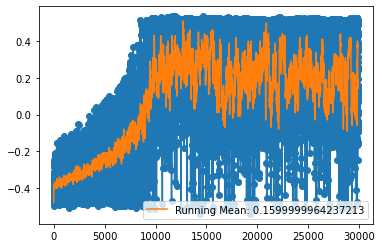

In [12]:
log_interval = 100  # How often do we update the plot? (Just for performance reasons)
### Here we set up the routine for the live plotting of the achieved points ######
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
##################################################################################

max_position_log = []  # to store all achieved points
mean_positions_log = []  # to store a running mean of the last 30 results
epochs = []  # store the epoch for plotting

for epoch in range(EPOCHS):
    ################################# TODO ######################################
    
    # TODO: Get initial observation and discretize them. Set done to False
    initial_state = env.reset()  # get the initial observation
    discretized_state = discretize_observation(initial_state, BINS)  # map the observation to the bins
    done = False  # to stop current run when the car reaches the top or the time limit is reached
    
    max_position = -np.inf  # for plotting
    epochs.append(epoch)
    
    # TODO: As long as current run is alive (i.e not done) perform the following steps:
    while not done:  # Perform current run as long as done is False (as long as there is still time to reach the top)


        # TODO: Select action according to epsilon-greedy strategy
        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)  # Epsilon-Greedy Action Selection
        
        # TODO: Perform selected action and get next state. Do not forget to discretize it
        next_state, reward, done, info = env.step(action)  # perform action and get next state
        position, velocity = next_state
        next_state_discretized = discretize_observation(next_state, BINS)  # map the next observation to the bins
        
        # TODO: Get old Q-value from Q-Table and get next optimal Q-Value
        old_q_value =  q_table[discretized_state + (action,)]  # get the old Q-Value from the Q-Table
        next_optimal_q_value = np.max(q_table[next_state_discretized])  # Get the next optimal Q-Value
        
        # TODO: Compute next Q-Value and insert it into the table
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)  # Compute next Q-Value
        q_table[discretized_state + (action,)] = next_q  # Insert next Q-Value into the table
        
        # TODO: Update the old state with the new one
        discretized_state = next_state_discretized  # Update the old state with the new one
        
        if position > max_position:  # Only for plotting the results - store the highest point the car is able to reach
            max_position = position

    # TODO: Reduce epsilon
    epsilon = reduce_epsilon(epsilon, epoch)  # Reduce epsilon
    ##############################################################################

    max_position_log.append(max_position)  # log the highest position the car was able to reach
    running_mean = round(np.mean(max_position_log[-30:]), 2)  # Compute running mean of position over the last 30 epochs
    mean_positions_log.append(running_mean)  # and log it
    
    ################ Plot the points and running mean ##################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, max_position_log)
        ax.plot(epochs, max_position_log)
        ax.plot(epochs, mean_positions_log, label=f"Running Mean: {running_mean}")
        plt.legend()
        fig.canvas.draw()
  ######################################################################

env.close()


**Test the agent using Q-Table and render its performance.**

In [13]:
observation = env.reset()
for counter in range(3000):
    env.render()
    
    # TODO: Get discretized observation
    discrete_state = discretize_observation(observation, BINS)  # Get discretized observation
    
    # TODO: Chose action from Q-Table
    action = np.argmax(q_table[discrete_state])  # and chose action from the Q-Table
    
    # TODO: Perform the action 
    observation, reward, done, info = env.step(action) # Finally perform the action
    
    if done:
        print(f"done")
        break
env.close()


done


**OPTIONAL: Play with our Q-Table with 40 bins per observation.**

In [14]:
np.save('40bin_qtable_mountaincar.npy',q_table)

In [15]:
our_q_table = np.load('40bin_qtable_mountaincar.npy')

In [16]:
our_q_table.shape

(40, 40, 3)